# Determinental Point Process (DPP)

This notebook demonstrates how to draw random samples from FiniteDPP process defined by a square exponential similarity kernel with different values of lenght_scale and prefactor. 

For each combination of lenght_scale and prefactor, we draw a random sample and compute the average and the standard deviation in the number of objects.

In [ ]:
#!pip install -U neptune-notebooks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy
from genus.util_ml import Grid_DPP
from genus.util_vis import show_batch

n_sampled=  1, n_expected=0.842 +/- 0.516, l=20, w=0.05
n_sampled=  1, n_expected=1.020 +/- 0.516, l=20, w=0.1
n_sampled=  1, n_expected=1.904 +/- 0.731, l=20, w=1
n_sampled=  3, n_expected=2.698 +/- 0.643, l=20, w=5
n_sampled=  3, n_expected=2.960 +/- 0.605, l=20, w=10
n_sampled=  1, n_expected=1.018 +/- 0.658, l=10, w=0.05
n_sampled=  1, n_expected=1.338 +/- 0.713, l=10, w=0.1
n_sampled=  2, n_expected=2.726 +/- 0.792, l=10, w=1
n_sampled=  3, n_expected=3.793 +/- 0.873, l=10, w=5
n_sampled=  4, n_expected=4.351 +/- 0.923, l=10, w=10
n_sampled=  0, n_expected=1.418 +/- 0.877, l=5, w=0.05
n_sampled=  1, n_expected=1.997 +/- 0.953, l=5, w=0.1
n_sampled=  5, n_expected=4.449 +/- 1.105, l=5, w=1
n_sampled=  7, n_expected=6.512 +/- 1.160, l=5, w=5
n_sampled=  8, n_expected=7.460 +/- 1.186, l=5, w=10
n_sampled=  2, n_expected=2.273 +/- 1.295, l=2, w=0.05
n_sampled=  3, n_expected=3.647 +/- 1.515, l=2, w=0.1
n_sampled= 11, n_expected=10.704 +/- 1.903, l=2, w=1
n_sampled= 15, n_expected=16.8

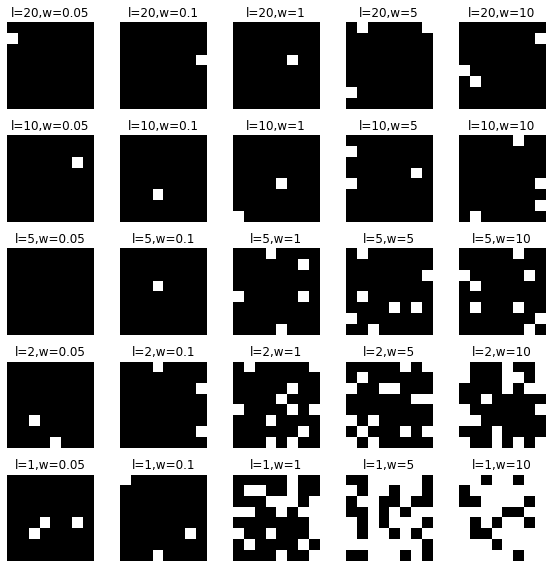

In [9]:
grid_size = 8
lenght_scales = [20, 10, 5, 2, 1]
weights = [0.05, 0.1, 1, 5, 10]

with torch.no_grad():
    fig, ax =  plt.subplots(ncols=len(weights), nrows=len(lenght_scales), figsize=(8,8))
    for row, l in enumerate(lenght_scales):
        for col, w in enumerate(weights):
            DPP = Grid_DPP(length_scale=l, weight=w)
        
            value = DPP.sample(size=torch.Size([grid_size, grid_size]))  # draw a random samples on a grid'
            n_sampled = value.sum(dim=(-1,-2)).item()
            logp = DPP.log_prob(value=value)
            n_av = DPP.n_mean.item()
            n_stddev = DPP.n_stddev.item()
            print("n_sampled={0:3d}, n_expected={1:.3f} +/- {2:.3f}, l={3}, w={4}".format(n_sampled, n_av, n_stddev, l, w))
        
            ax[row,col].axis('off')
            ax[row,col].imshow(value, cmap='gray')
            ax[row,col].set_title("l={0},w={1}".format(l,w))
    fig.tight_layout()
    fig.savefig("./DPP_samples.png")

# Choose one setting

You can change the value of lenght_scale and weight till you find the combination which generates the expected number of samples

In [ ]:
grid_size = 8

DPP = Grid_DPP(length_scale=5, weight=0.3)
value = DPP.sample(size=torch.Size([grid_size, grid_size]))
print("n_avg ={0:.3f}, n_stdev={1:.3f}".format(DPP.n_mean.item(), DPP.n_variance.item()))

# Draw many samples for that setting

Now we draw many random sample and compute the empirical density.
Note that due to the DPP repulsion the particle density is enhanced close to the boundaries

In [ ]:
n_samples=5000
value = DPP.sample(size=torch.Size([n_samples, grid_size, grid_size]))
print("configurations.shape ->",value.shape)

Visualize few samples

In [ ]:
show_batch(value[:20].unsqueeze(-3).float(), n_col=5, pad_value=0.5, n_padding=1, 
           title="Few random samples", figsize=(12,6))

Visualize empirical density and object number distribution

In [ ]:
print("configurations.shape ->",value.shape)

fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(16, 4))

axes[0].set_title("Average density")
density = axes[0].imshow(value.float().mean(dim=-3))
axes[0].grid(color='white')
axes[0].set_xticks(ticks=torch.arange(value.shape[-1])-0.5)
axes[0].set_yticks(ticks=torch.arange(value.shape[-2])-0.5)
axes[0].set_xticklabels(labels="")
axes[0].set_yticklabels(labels="")
fig.colorbar(density, ax=axes[0])

axes[1].set_title("One random sample")
axes[1].imshow(value[0])
axes[1].grid()
axes[1].set_xticks(ticks=torch.arange(value.shape[-1])-0.5)
axes[1].set_yticks(ticks=torch.arange(value.shape[-2])-0.5)
axes[1].set_xticklabels(labels="")
axes[1].set_yticklabels(labels="")

axes[2].set_title("Another random sample")
axes[2].imshow(value[1])
axes[2].grid()
axes[2].set_xticks(ticks=torch.arange(value.shape[-1])-0.5)
axes[2].set_yticks(ticks=torch.arange(value.shape[-2])-0.5)
axes[2].set_xticklabels(labels="")
axes[2].set_yticklabels(labels="")

# Make Histogram of the number of particles samples from DPP
n_particles = value.sum(dim=(-1,-2))
counts = torch.bincount(n_particles).float() 
counts /= counts.sum()

n_avg = DPP.n_mean.item()
n_var = DPP.n_variance.item()
n_stddev = DPP.n_stddev.item()
n_min = n_particles.min().item()
n_max = n_particles.max().item()

print("n_avg={0:.3f}, n_std={1:.3f}".format(n_avg,n_stddev))
print("n_min={0}, n_max={1}".format(n_min,n_max))

x = torch.linspace(n_min,n_max,100)
y = torch.exp(-(x-n_avg)**2/(2*n_var)) / numpy.sqrt(2*numpy.pi*n_var)

axes[3].set_title("Histogram number of particles")    
_ = axes[3].bar(torch.arange(counts.shape[0]), counts)
_ = axes[3].plot(x,y,label="Gaussian Fit")
_ = axes[3].set_xticks(ticks=torch.arange(n_max))
_ = axes[3].set_xlabel("number of particles")
_ = axes[3].legend(loc='upper right')